<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Modelling_traffic_2_Detectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [64]:
controller_data = pd.read_csv('2_detectors.csv')

In [65]:
controller_data["5 Minutes"] = pd.to_datetime(controller_data["5 Minutes"])
controller_data.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow = controller_data[['Flow1 (Veh/5 Minutes)', 'Flow2 (Veh/5 Minutes)']]

print(time_flow)

                     Flow1 (Veh/5 Minutes)  Flow2 (Veh/5 Minutes)
5 Minutes                                                        
2024-10-23 00:00:00                    171                     78
2024-10-23 00:05:00                    157                     67
2024-10-23 00:10:00                    165                     78
2024-10-23 00:15:00                    145                     66
2024-10-23 00:20:00                    153                     67
...                                    ...                    ...
2024-10-29 23:35:00                    172                     83
2024-10-29 23:40:00                    185                     95
2024-10-29 23:45:00                    195                    105
2024-10-29 23:50:00                    159                     71
2024-10-29 23:55:00                    186                     87

[2016 rows x 2 columns]


In [66]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [67]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train), :], flow_normalised[int(train):, :]

In [68]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 2
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)

print(X_train.shape)

# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

(1610, 2, 2)


In [96]:
from keras import layers

input_layer = keras.layers.Input(shape=(look_back, 2))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(2, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 2, 2)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 2, 64)               │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_7 (RepeatVector)       │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 2, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 2, 2)                │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,530 (213.01 KB)

 Trainable params: 54,530 (213.01 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.2459 - val_loss: 0.0565
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0451 - val_loss: 0.0268
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0183 - val_loss: 0.0081
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - val_loss: 0.0086
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0074
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0072
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0067
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0058
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_

In [98]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [99]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(2, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1077 - val_loss: 0.0210
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0084
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0081
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0076
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0073
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0071
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0069
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0059


In [100]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [101]:
temp_val_1 = np.zeros((y_val.shape[0], 2))
temp_pred_1 = np.zeros((y_pred.shape[0], 2))

temp_val_1[:, 0] = y_val[:, 0]
temp_pred_1[:, 0] = y_pred[:, 0]

# Rescale the predicted values and actual values to their original scale
y_val_detector_1_rescaled = scaler.inverse_transform(temp_val_1)[:, 0]
y_pred_detector_1_rescaled = scaler.inverse_transform(temp_pred_1)[:, 0]

In [102]:
temp_val_2 = np.zeros((y_val.shape[0], 2))
temp_pred_2 = np.zeros((y_pred.shape[0], 2))

temp_val_2[:, 1] = y_val[:, 1]
temp_pred_2[:, 1] = y_pred[:, 1]

# Rescale the predicted values and actual values to their original scale
y_val_detector_2_rescaled = scaler.inverse_transform(temp_val_2)[:, 1]
y_pred_detector_2_rescaled = scaler.inverse_transform(temp_pred_2)[:, 1]

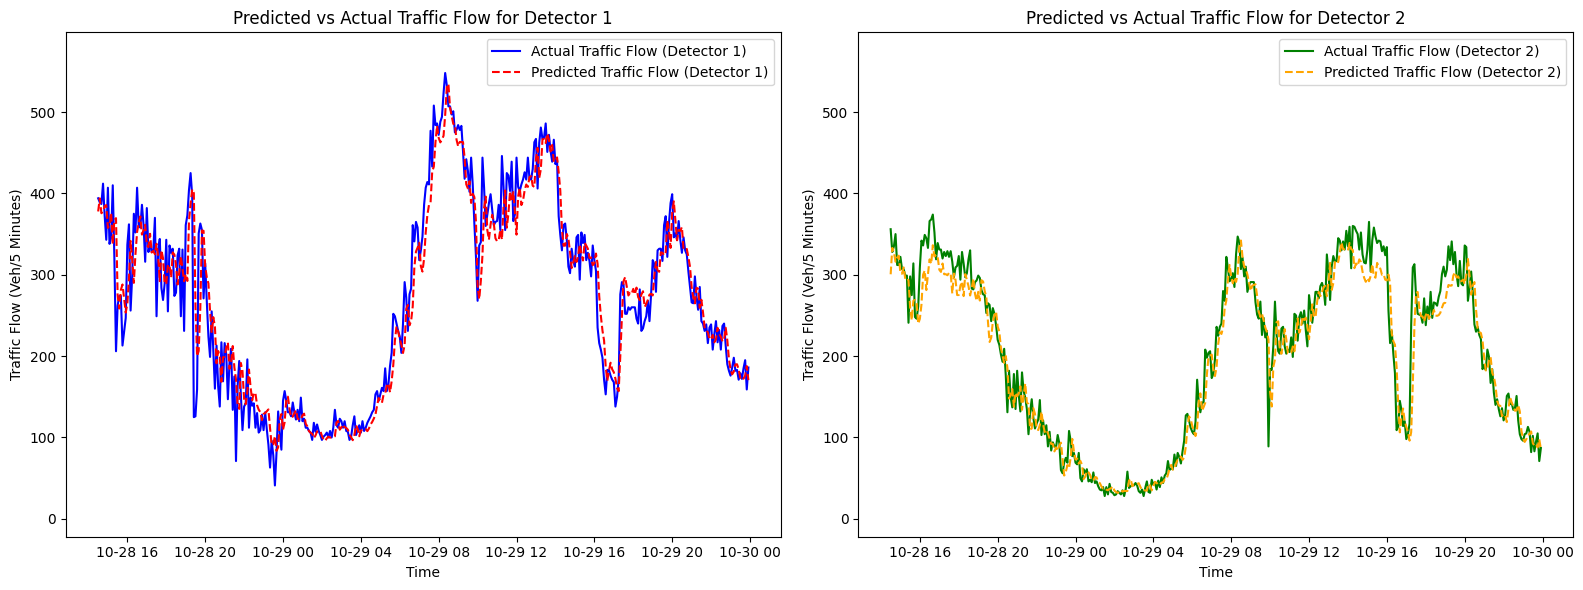

In [103]:
import matplotlib.pyplot as plt

timestamps = time_flow.index[-len(y_val):]

# Define figure and axes for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# First plot on ax1 (Actual vs Predicted for Detector 1)
ax1.plot(timestamps, y_val_detector_1_rescaled, label='Actual Traffic Flow (Detector 1)', color='blue')
ax1.plot(timestamps, y_pred_detector_1_rescaled, label='Predicted Traffic Flow (Detector 1)', color='red', linestyle='--')
ax1.set_xlabel('Time')
ax1.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax1.set_title('Predicted vs Actual Traffic Flow for Detector 1')
ax1.legend()

# Second plot on ax2 (Actual vs Predicted for Detector 2)
ax2.plot(timestamps, y_val_detector_2_rescaled, label='Actual Traffic Flow (Detector 2)', color='green')
ax2.plot(timestamps, y_pred_detector_2_rescaled, label='Predicted Traffic Flow (Detector 2)', color='orange', linestyle='--')
ax2.set_xlabel('Time')
ax2.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax2.set_title('Predicted vs Actual Traffic Flow for Detector 2')
ax2.legend()

# Set the same y-axis limits for both plots
# Find the min and max values across both detectors
y_min = min(y_val_detector_1_rescaled.min(), y_pred_detector_1_rescaled.min(), y_val_detector_2_rescaled.min(), y_pred_detector_2_rescaled.min()) - 50
y_max = max(y_val_detector_1_rescaled.max(), y_pred_detector_1_rescaled.max(), y_val_detector_2_rescaled.max(), y_pred_detector_2_rescaled.max()) + 50

# Set the y-axis limits for both plots
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()
